## Lab 3

### Part 2. Almost Shakespeare (2.0 points)

В этой части задания мы научимся генерировать текст с помощью нейронных сетей. Конкретнее, обучим нейронную сеть на сонетах Шекспира и попросим нейросеть написать свой сонет.

Генерация текста обычно включает в себя следующие шаги:
    
1. Загрузка данных.
2. Создание словарей слов/символов.
3. Препроцессинг данных.
4. Обучение модели (нейросети).
5. Генерация нового текста.


#### Часть 1. Предобработка данных

Для начала загрузим данные. Файл с сонетами Шекспира доступен по [ссылке](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). Кроме того, он находится рядом с этим ноутбуком (`sonnetes.txt`).

Базовая предобработка уже сделана: текст состоит непосредственно из поэм Шекспира и названий/номеров глав, все техническая информация удалена.

In [ ]:
import string

In [ ]:
with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START:TEXT_END]
assert len(text) == 2616

Так как в этот раз мы хотим научиться предсказывать текст, понизим сложность задачи и приведем текст к нижнему регистру.

В настоящий момент переменная `text` представляет собой список из строк. Объедините все строки в одну и приведите к нижнему регистру. 

In [ ]:
# Объедините все строки в одну и приведите к нижнему регистру.
# Результат запишите в переменную text.

text = (''.join(text)).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('Отлично!')

Отлично!


Выделите множество всех символов, с которыми нам довелось встретиться в переменную `tokens`.

In [ ]:
tokens = sorted(set(text))

Постройте словарь `token_to_idx` вида <символ>: <индекс> и словарь `idx_to_token` вида <индекс>: <символ>.

In [ ]:
# словарь вида <индекс>:<символ>
id_to_token = {t:i for t, i in enumerate(tokens)}

# словарь вида <символ>:<индекс>
token_to_id = {i:t for t, i in id_to_token.items()}

*Комментарий: т.к. у нас всего 38 различных токенов, в этот раз воспользуемся one-hot encoding'ом.*


## Построение модели.

Теперь наша задача - создать и обучить рекуррентную нейронную сеть, которая сможет генерировать что-то похожее на поэзию Шекспира.

Для начала воспользуемся классической RNN, аналогичной построенной на семинаре. 

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

class RNN(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=128, rnn_num_units=1024):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev, temperature=1):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)#YOUR CODE HERE
        h_next = self.rnn_update(x_and_h)#YOUR CODE HERE
        
        h_next = torch.tanh(h_next)#YOUR CODE HERE
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)#YOUR CODE
        
        return h_next, F.log_softmax(logits / temperature, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [ ]:
from torch.utils.data import DataLoader

ids = [token_to_id[t] for t in text]
prefix_len = 100
samples = [torch.LongTensor(ids[i*prefix_len:(i+1)*prefix_len]) for i in range(len(ids)//prefix_len)]
batcher = DataLoader(samples, batch_size=32)

In [ ]:
def rnn_loop(rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = rnn.initial_state(batch_size).to(device)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from IPython.display import clear_output
from random import sample
import numpy as np
from matplotlib import pyplot as plt

rnn = RNN().to(device)
opt = torch.optim.Adam(rnn.parameters(), lr = 0.001)
history = []
n_epoch = 150

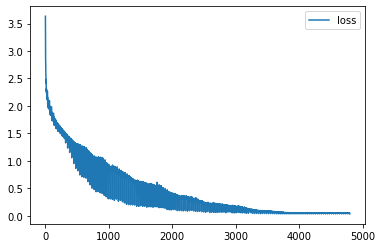

In [ ]:
for ep in range(n_epoch):
    for i, batch_ix in enumerate(batcher):
      batch_ix = torch.LongTensor(batch_ix).to(device)
      #print(batch_ix.size())
      logp_seq = rnn_loop(rnn, batch_ix)

      predictions_logp = logp_seq[:, :-1]
      actual_next_tokens = batch_ix[:, 1:]

      logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])

      loss = -logp_next.mean()
      loss.backward()
      opt.step()
      opt.zero_grad()
      #scheduler.step(loss.item())
      
      history.append(loss.data.cpu().numpy())
    clear_output(True)
    plt.plot(history,label='loss')
    plt.legend()
    plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Постройте график функции потерь в зависимости от номера эпохи.

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


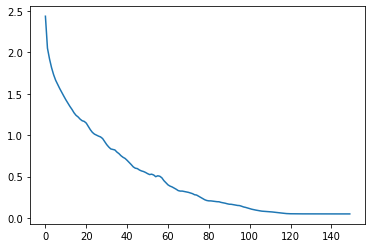

In [ ]:
plt.plot([np.mean(history[i*len(batcher):(i+1)*len(batcher)]) for i in range(n_epoch+1)])

In [ ]:
print(np.mean(history[-len(batcher)]))

0.053912703


In [ ]:
def generate_text(length=100, temperature=1):
    hid_state = rnn.initial_state(1).to(device)
    past = sample(tokens, 1)
    #past = list(text[:15])
    for i in range(length):
         x = torch.LongTensor([token_to_id[past[-1]]]).to(device)
         hid_state, logit = rnn(x, hid_state, temperature=temperature)
         past.append(id_to_token[torch.multinomial(torch.exp(logit), 1)[0].item()])
    return ''.join(past)

In [ ]:
# Пример сгенерированного текста. Функция `generate_text` отсутствует в коде выше. Реализуйте ее самостоятельно.
print(generate_text(length=1000, temperature=0.2))

! what a happy title do i find,
  happy to have thy love, happy to die!
    but what's so blessed-face,
  sweet beauty hath no name, no holy bower,
  but is profan'd, if not lives in disgrace with fortune and men's eyes
  i all alone beweep my outcast strangely pass,
  and scarcely greet me with that muse,
  stirr'd by a painted beauty to his verse,
  who hast by waning grown, and therein show'st
  thy beauty grow,
    the pain be mine own desert,
  and hang more praise upon deceased i
  than niggard truth upon shadow of your beauty show,
  the other as your bounty die aud the judgment of my heart is tied?
  why should my heart think that a several plot,
  which my jede live:
  against this coming end you should prepare,
  and your sweet semblance to some other pattern to succeeds.

  cxxxvii

  thou blind fool, love, what dost thou use
  so great a sum of sums, your charter is store;
  buy terms divine in selling hours of dross;
  within by that i prove,
    love's fire heats water fo

### Более поэтичная модель

Теперь давайте воспользуемся LSTM слоем вместо классической RNN и сравним результаты.

Снова постройте график функции потерь от числа эпох. Стал ли финальный loss лучше?

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

class LSTM(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=128, rnn_num_units=1024):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.lstm = nn.LSTM(embedding_size, rnn_num_units, batch_first=True)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev, temperature=1):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x).unsqueeze(1)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        #x_and_h = torch.cat([x_emb, h_prev], dim=-1)#YOUR CODE HERE
        x, (h, c) = self.lstm(x_emb, h_prev)#YOUR CODE HERE
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(x[:, -1])#YOUR CODE
        
        return (h, c), F.log_softmax(logits / temperature, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return (torch.zeros(1, batch_size, self.num_units, requires_grad=True), 
                     torch.zeros(1, batch_size, self.num_units, requires_grad=True))

In [ ]:
lstm = LSTM().to(device)
opt = torch.optim.Adam(lstm.parameters(), lr = 0.001)
history = []
n_epoch = 100

In [ ]:
def rnn_loop(rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = rnn.initial_state(batch_size)
    if isinstance(hid_state, tuple):
       hid_state = (hid_state[0].to(device), hid_state[1].to(device))
    else:
      hid_state = hid_state.to(device).unsqueeze(-1)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

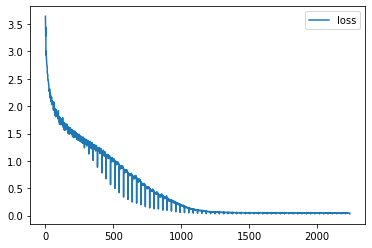

KeyboardInterrupt: ignored

In [ ]:
for ep in range(n_epoch):
    for i, batch_ix in enumerate(batcher):
      batch_ix = torch.LongTensor(batch_ix).to(device)
      #print(batch_ix.size())
      logp_seq = rnn_loop(lstm, batch_ix)

      predictions_logp = logp_seq[:, :-1]
      actual_next_tokens = batch_ix[:, 1:]

      logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])

      loss = -logp_next.mean()
      loss.backward()
      opt.step()
      opt.zero_grad()
      #scheduler.step(loss.item())
      
      history.append(loss.data.cpu().numpy())
    clear_output(True)
    plt.plot(history,label='loss')
    plt.legend()
    plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


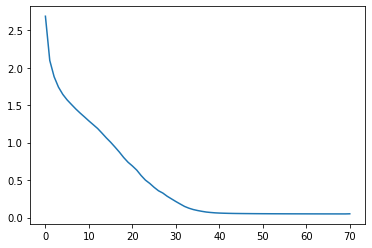

In [ ]:
plt.plot([np.mean(history[i*len(batcher):(i+1)*len(batcher)]) for i in range(n_epoch+1)])

In [ ]:
print(np.mean(history[-len(batcher)]))

0.04817187


In [ ]:
def generate_text(length=100, temperature=1):
    hid_state = lstm.initial_state(1)
    hid_state = [x.to(device) for x in hid_state]
    past = sample(tokens, 1)
    #past = list(text[:15])
    for i in range(length):
         x = torch.LongTensor([token_to_id[past[-1]]]).to(device)
         hid_state, logit = lstm(x, hid_state, temperature=temperature)
         past.append(id_to_token[torch.multinomial(torch.exp(logit), 1)[0].item()])
    return ''.join(past)

Сгенерируйте текст с помощью обученной сети для различных значений параметра `temperature`: `[0.1, 0.2, 0.5, 1.0, 2.0]` ("температуры" при генерации). Оцените результаты визуально, попробуйте их проинтерпретировать.

In [ ]:
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f'============= Temperature {t} ==============')
    print(generate_text(length=1000, temperature=t))

============= Temperature 0.1 ==============
y will in thine?
  shall will in others seem right gracious,
  and in my will no fair acceptance shill,
  to the sen a form upon desired change,
  as i'll myself disgrace; knowing thy will, thy might,
    when you live in this and much enrich thy book.

  lxxviii

  so oft have i invoked thee for my muse,
  and found to slave thou would be forgot,
  if thinking on me then should make you woe.
    you to your beauteous blessings add a curse,
    being fone, thou hast thy love, and thy dear virtue hate,
  hate of my sin, grounded on sinful loving:
  o! lest your soul and his well time's full will pring,
  and worse of many now is thine alone:
    their imagess you wilt thou that i wome comfort now are therefore to be strong,
    that in the every oner hast calls thee to the heart
  of bird, of flowers in odour and in hue,
  could make me any summer's story tell,
    and my thoughts, all thy beauty thou wilt thou art believe me,
  looking with 

Здесь можно оставить свои рассуждения касательно интерпретации результатов.

По идее при меньшей температуре текст должен быть менее разнообразный, из частых и простых слов, без сложных конструкций. А при большей температуре более шумный и разнообразный.

#### Сохранение и загрузка модели

Сохраните обученную модель на диск, затем загрузите ее и сгенерируйте текст. Примеры доступны по [ссылке](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
torch.save(lstm.state_dict(), 'lstm_sd.pt')
lstm.load_state_dict(torch.load('lstm_sd.pt'))
print(generate_text(length=1000, temperature=0.1))

pends upon that love of thine.
  then need i not to fear the worst of wrongs,
  when in the least of whoth they see
  return of love, more blessed than living lips.
    since saucy jacks so happy are in this,
  and pursuit on his love hath made my foes,
  that they elsewhere might dart their injuries:
    yet do not so; but then it was nourish'd by.
    this thou perceiv'st, why dost thou mayst upon make the strength of laws,
    since why to love i can allege no cause.

  l

  how heavy do i joy thou art belov'd, i new aprov

  xxiii

  so all my love, to whom in vassaly beauty shill,
  that heaven's air in this huge rondure hems.
  o! let me, true in love, to thy sour like to conspare,
  coreating thou this powerful might,
  with insufficiency my heart to sway?
  to make me give the lie to my true sightless every where.
  o! let me both side his contine age,
    stealing was i writ in my makenty criested story,
  which have no correspondence with true sight;
  or, if they have, which

Данная часть задания завершена.

#### Полезные ссылки
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Статья Андрея Карпатого про RNN. </a> В качестве примеров рассматриваются задачи генерации Шекспировских текстов, Latex формул, Linux Source Code и детских имен.
2. <a href='https://github.com/karpathy/char-rnn'> Репозиторий с кодом по char-rnn </a> (тоже за авторством Андрея Карпатого)
3. Полезный репозиторий по PyTorch: [ссылка](https://github.com/spro/practical-pytorch`)